In [1]:
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt

from livecellx.core.datasets import LiveCellImageDataset
from livecellx.sample_data import tutorial_three_image_sys

from livecellx.trajectory.feature_extractors import compute_haralick_features, compute_skimage_regionprops
from livecellx.preprocess.utils import normalize_img_to_uint8
from livecellx.core.parallel import parallelize
from livecellx.core.io_sc import prep_scs_from_mask_dataset
from livecellx.core.single_cell import SingleCellTrajectoryCollection, create_sc_table
import livecellx.core.single_cell
from livecellx.core.single_cell import SingleCellStatic
from livecellx.core.io_utils import LiveCellEncoder



## Load datasets

load CTC or CX-A data

In [2]:

# # dataset_dir_path = Path(
# #     "../datasets/celltrackingchallenge/BF-C2DL-HSC/BF-C2DL-HSC/01"
# # )


# dataset_dir_path = Path(
#     # r"../datasets/cxa-high-density/contrast_enhanced_factor=3_png_data/C10^3_wellC7_RI_MIP_stitched",
#      r"../datasets/cxa-high-density/contrast_enhanced_factor=3_png_data/C0.5^4_wellE6_RI_MIP_stitched",
# )

# # mask_dataset_path = Path("../datasets/celltrackingchallenge/DIC-C2DH-HeLa/DIC-C2DH-HeLa/01_GT/TRA")
# # mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="tif")
# def extract_mask_time(filename):
#     """seg_{time}.png -> time"""
#     return int(filename.split("_")[1].split(".")[0])

# # mask_dataset_dir = Path(r"./application_results/celltrackingchallenge/dic-hela_segmentation_cellpose_tn1/seg")
# # mask_time2url_paths = sorted(glob.glob(str((Path(mask_dataset_dir) / Path("*.png")))))
# # mask_time2url = {extract_mask_time(Path(path).name): path for path in mask_time2url_paths}
# # mask_dataset = LiveCellImageDataset(time2url=mask_time2url, ext="png")

# time2url = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*.png")))))
# time2url = {i: path for i, path in enumerate(time2url)}
# img_dataset = LiveCellImageDataset(time2url=time2url, ext="png")



load EBSS 120hrs data XY09

In [3]:
# EBSS_120hrs_XY09_folder = r"E:\xing-imaging\tifs_CFP_A549_VIM_120hr_NoTreat_NA_YL_Ti2e_2023-03-22\tifs_CFP_A549_VIM_120hr_NoTreat_NA_YL_Ti2e_2023-03-22\XY09\DIC"

# # filename sample: CFP_A549_VIM_120hr_NoTreat_NA_YL_Ti2e_2023-03-22 _T0001_XY09_DIC.tif
# EBSS_120hrs_XY09_time2url = sorted(glob.glob(str((Path(EBSS_120hrs_XY09_folder) / Path("*.tif")))))
# img_dataset = LiveCellImageDataset(time2url={i: path for i, path in enumerate(EBSS_120hrs_XY09_time2url)}, ext="tif")

In [4]:
# list(img_dataset.time2url.items())[:5]

In [5]:
# len(img_dataset), img_dataset.time2url

In [6]:
# for time in sc_img_dataset.time2url:
#     print("sc:", sc_img_dataset.time2url[time])
#     print("img:", img_dataset.time2url[time])

In [7]:
# annotation_dir = Path("../datasets/mitosis-annotations-2023/shiman_CXA_normal/C10^3")
# annotation_dir = Path("../datasets/mitosis-annotations-2023/shiman_CXA_normal/C0.5^4")
# annotation_dir = Path("../datasets/mitosis-annotations-2023/shiman_CXA_normal/C0.5^4_wellE6_RI_MIP_stitched")
annotation_dir = Path("../datasets/mitosis-annotations-2023/shiman_CXA_high_density/C10^4")
# annotation_dir = Path(r"../datasets/mitosis-annotations-2023/shiman_XY09/XY09")
# annotation_dir = Path(r"../datasets/mitosis-annotations-2023/shiman_XY10/XY10")
# classes = ["normal"]
classes = ["mitosis"]

In [8]:
from livecellx.track.classify_utils import load_all_json_dirs


class2samples, class2samples_extra_info = load_all_json_dirs([annotation_dir], class_subfolders=classes)


|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_012b5ad1-8896-4cd8-a36c-ae97779af9f2.json
|-----> loaded 11 single cells
|-----> constructing single cells from json dict...


constructing single cells from json dict: 100%|██████████| 11/11 [00:00<00:00, 47.98it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_12834300-41ab-4e15-b50d-f386482b3cbd.json
|-----> loaded 9 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 9/9 [00:00<00:00, 210.72it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_22cbbdee-e6b1-4d8b-b6df-2f76114e4678.json
|-----> loaded 11 single cells


|-----> constructing single cells from json dict...


constructing single cells from json dict: 100%|██████████| 11/11 [00:00<00:00, 232.05it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_2b292c79-801e-4cb0-a6d2-7aaf1a6b2a2e.json


|-----> loaded 7 single cells
|-----> constructing single cells from json dict...


constructing single cells from json dict: 100%|██████████| 7/7 [00:00<00:00, 226.45it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_56a18532-9b89-4498-8e87-32150f2a4e39.json
|-----> loaded 12 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 12/12 [00:00<00:00, 246.45it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_6643c031-fe39-4b86-add4-69641f9326dd.json
|-----> loaded 10 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 10/10 [00:00<00:00, 244.43it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_7b7cf42d-6155-4faa-9523-345042e613e8.json
|-----> loaded 12 single cells


|-----> constructing single cells from json dict...


constructing single cells from json dict: 100%|██████████| 12/12 [00:00<00:00, 245.08it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_a92298ac-f2b4-402a-a82d-563a6ded8f26.json
|-----> loaded 10 single cells


|-----> constructing single cells from json dict...


constructing single cells from json dict: 100%|██████████| 10/10 [00:00<00:00, 167.58it/s]

|-----> done constructing single cells from json dict
Loaded 8 annotated samples from ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis


In [9]:
all_scs = SingleCellStatic.load_single_cells_json(annotation_dir/"single_cells.json")

|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\single_cells.json
|-----> loaded 82 single cells
|-----> constructing single cells from json dict...


constructing single cells from json dict: 100%|██████████| 82/82 [00:00<00:00, 14865.06it/s]

|-----> done constructing single cells from json dict


Compute the features  
Read the features in the next section if you already computed the features.

In [10]:
# from livecellx.core.io_sc import prep_scs_from_mask_dataset
# scs = prep_scs_from_mask_dataset(mask_dataset, img_dataset)

annotated_scs = []
for cls in class2samples:
    for samples in class2samples[cls]:
        annotated_scs.extend(samples)

In [11]:
from typing import List
from livecellx.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours,
    track_SORT_bbox_from_scs
)

sc_img_dataset = annotated_scs[0].img_dataset
sdata = track_SORT_bbox_from_scs(annotated_scs, sc_img_dataset, max_age=0, min_hits=1)

In [12]:
# sct_sample_dict = {}
# for cls in class2samples:
#     sct_sample_dict[cls] = []
#     for i, sample in enumerate(class2samples[cls]):
#         if len(sample) == 0:
#             continue
#         assert '_annotation_label_info' in sample[0].meta, "sample[0].meta should have '_annotation_label_info'"
#         annotation_label_infos = sample[0].meta['_annotation_label_info']
#         annotation_label_info = None
#         for info in annotation_label_infos:
#             if info['label'] == cls:
#                 annotation_label_info = info
#                 break
#         assert annotation_label_info is not None, "sc meta shoud contain annotation_label_info == cls: {}".format(cls)
#         sample_id = annotation_label_info['sample_id']
#         sample_dict = {"sample": sample, "sample_id": sample_id}
#         sct_sample_dict[cls].append(sample_dict)


In [13]:
all_scs[0].meta

{'_annotation_label_info': [{'label': 'mitosis',
   'sample_id': 'a92298ac-f2b4-402a-a82d-563a6ded8f26'}],
 'img_dataset_json_path': '../datasets/mitosis-annotations-2023/shiman_CXA_high_density/C10^4/datasets/livecell-dataset-d8f7358e-d915-420f-8e65-d2fb807fa2c8.json',
 'mask_dataset_json_path': '../datasets/mitosis-annotations-2023/shiman_CXA_high_density/C10^4/datasets/livecell-dataset-b632c61b-1b4c-4320-ab2d-c52ff6f6fc7a.json'}

Set the labels of sc

In [14]:
for sc in annotated_scs:
    for i in range(len(sc.meta["_annotation_label_info"])):
        sc.meta["_annotation_label_info"][i]["label"] = "someLabel"

In [15]:
from livecellx.core.single_cell import (
    SingleCellTrajectoryCollection,
    SingleCellStatic,
    SingleCellTrajectory,
    create_sctc_from_scs,
    filter_sctc_by_time_span,
)

from livecellx.core.sct_operator import create_sctc_edit_viewer_by_interval, create_scs_edit_viewer_by_interval
tmp_sctc = create_sctc_from_scs(annotated_scs)
# tmp_sctc = create_sctc_from_scs(all_scs)
# sct_operator = create_sctc_edit_viewer_by_interval(tmp_sctc, img_dataset=img_dataset, span_interval=1500, contour_sample_num=15)

In [28]:
import importlib
import livecellx
import livecellx.core.sct_operator
importlib.reload(livecellx.core.sct_operator)
sc_img_dataset = annotated_scs[0].img_dataset
# sct_operator = livecellx.core.sct_operator.create_scs_edit_viewer_by_interval(annotated_scs, img_dataset=sc_img_dataset, span_interval=1500, contour_sample_num=50)
sct_operator = livecellx.core.sct_operator.create_sctc_edit_viewer_by_interval(sdata, img_dataset=sc_img_dataset, span_interval=1500, contour_sample_num=50)

|-----> viewer is None, creating a new viewer...
|-----> Creating a new viewer with the img_dataset...
|-----> Creating a new shape layer...
|-----> Skipping adding shapes to the shape layer...
|-----------> Number of trajectories: 0
|-----------> Calling viewer.add_shapes to add trajectories to napari
|-----------> Time to add shapes: 0.116809
|-----> storing sct shapes information...
|-----> storing sct shapes information complete, seconds: 0.0
>>> debug: cur_idx span


c:\Users\dummy\anaconda3\envs\livecell-work\lib\site-packages\napari\utils\colormaps\standardize_color.py:200: UserWarning: Given color input is empty. Converting input to a white color array.
  warnings.warn(


|-----> [sctc render by interval] sct operator: moving interval
clearing selection...
<clear complete>
|-----> setting up shape layer by time span: (0, 1500)
|-----------> contour_sample_num: 50
|-----> Generating Shapes in napari...
|-----------> Number of trajectories: 16
|-----------> Calling viewer.add_shapes to add trajectories to napari
|-----------> Time to add shapes: 0.733223
|-----> Setting up shape layer...
|-----> storing sct shapes information...
|-----> storing sct shapes information complete, seconds: 0.0


toggle shapes text fired!
current shape layer shape properties:  Event
setting face color of selected shape...
<selection complete>
current shape layer shape properties:  Event
shape already selected, please select another shape
toggle shapes text fired!
toggle shapes text fired!
toggle shapes text fired!


load the annotations

In [17]:
sct_operator.load_annotations([annotation_dir], classes=classes)

|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_012b5ad1-8896-4cd8-a36c-ae97779af9f2.json
|-----> loaded 11 single cells
|-----> constructing single cells from json dict...


constructing single cells from json dict: 100%|██████████| 11/11 [00:00<00:00, 5497.12it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_12834300-41ab-4e15-b50d-f386482b3cbd.json
|-----> loaded 9 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 9/9 [00:00<00:00, 5975.74it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_22cbbdee-e6b1-4d8b-b6df-2f76114e4678.json
|-----> loaded 11 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 11/11 [00:00<00:00, 5774.39it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_2b292c79-801e-4cb0-a6d2-7aaf1a6b2a2e.json
|-----> loaded 7 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 7/7 [00:00<00:00, 7003.85it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_56a18532-9b89-4498-8e87-32150f2a4e39.json
|-----> loaded 12 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 12/12 [00:00<00:00, 12000.87it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_6643c031-fe39-4b86-add4-69641f9326dd.json
|-----> loaded 10 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 10/10 [00:00<00:00, 10019.84it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_7b7cf42d-6155-4faa-9523-345042e613e8.json
|-----> loaded 12 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 12/12 [00:00<00:00, 5990.44it/s]

|-----> done constructing single cells from json dict
|-----> loading single cells from json file: ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis\sample_a92298ac-f2b4-402a-a82d-563a6ded8f26.json
|-----> loaded 10 single cells
|-----> constructing single cells from json dict...



constructing single cells from json dict: 100%|██████████| 10/10 [00:00<00:00, 9988.82it/s]

|-----> done constructing single cells from json dict
Loaded 8 annotated samples from ..\datasets\mitosis-annotations-2023\shiman_CXA_high_density\C10^4\mitosis


In [18]:
len(sc_img_dataset)

184

In [19]:
sc_annotation_labels = []
sc_annotation_labels_strs = []
for sc in sct_operator.shape_layer.properties["sc"]:
    sc_annotation_labels.append([])
    sc_annotation_labels_strs.append("")
    if "_annotation_label_info" not in sc.meta:
        continue
    for info in sc.meta["_annotation_label_info"]:
        sc_annotation_labels[-1].extend([info["label"]])
    sc_annotation_labels[-1] = list(set(sc_annotation_labels[-1]))
    annotation_repr = ",".join(sc_annotation_labels[-1])
    sc_annotation_labels_strs[-1] = annotation_repr

all_properties = sct_operator.shape_layer.properties
all_properties["annotation_labels"] = sc_annotation_labels_strs
sct_operator.shape_layer.properties = all_properties
sct_operator.shape_layer.text = "annotation_labels"

In [20]:
sct_operator.shape_layer.properties.keys()

dict_keys(['track_id', 'sc', 'status', 'annotation_labels'])

In [21]:
sct_operator.shape_layer.properties.keys()

dict_keys(['track_id', 'sc', 'status', 'annotation_labels'])

In [22]:
# # out_dir = Path("./tmp/DIC-C2DH-HeLa/01_annotation")
# out_dir = Path("./tmp/fixed_annotations")
# out_dir.mkdir(exist_ok=True, parents=True)
# sct_operator.save_annotations(out_dir)

In [23]:
# from livecellx.core.sc_seg_operator import create_sc_seg_napari_ui
# from livecellx.core.sct_operator import create_sctc_edit_viewer_by_interval, create_scs_edit_viewer_by_interval
# from livecellx.core.single_cell import (
#     SingleCellTrajectoryCollection,
#     SingleCellStatic,
#     SingleCellTrajectory,
#     create_sctc_from_scs,
#     filter_sctc_by_time_span,
# )

# import importlib
# importlib.reload(livecellx.core.sct_operator)

# tmp_sdata = create_sctc_from_scs(sdata.get_all_scs())
# sct_operator = livecellx.core.sct_operator.create_sctc_edit_viewer_by_interval(tmp_sdata, img_dataset, span_interval=1000)

Set annotation labels

In [24]:
sc_annotation_labels = []
sc_annotation_labels_strs = []
for sc in sct_operator.shape_layer.properties["sc"]:
    sc_annotation_labels.append([])
    sc_annotation_labels_strs.append("")
    if "_annotation_label_info" not in sc.meta:
        continue
    for info in sc.meta["_annotation_label_info"]:
        sc_annotation_labels[-1].extend([info["label"]])
    sc_annotation_labels[-1] = list(set(sc_annotation_labels[-1]))
    annotation_repr = ",".join(sc_annotation_labels[-1])
    sc_annotation_labels_strs[-1] = annotation_repr

all_properties = sct_operator.shape_layer.properties
all_properties["annotation_labels"] = sc_annotation_labels_strs
sct_operator.shape_layer.properties = all_properties
sct_operator.shape_layer.text = "annotation_labels"

In [25]:
# from livecellx.core.io_sc import prep_scs_from_mask_dataset
# scs = prep_scs_from_mask_dataset(mask_dataset, img_dataset)

In [26]:
# from livecellx.track.movie import generate_single_trajectory_movie

# for track_id, traj in traj_collection:
#     generate_single_trajectory_movie(traj, save_path= out_dir / f"track_{track_id}.gif")

start timeframe larger than the first timeframe of the trajectory, replace start_timeframe with the first timeframe...


array([[<Axes: title={'center': 'time: 19'}>,
        <Axes: title={'center': 'time: 20'}>,
        <Axes: title={'center': 'time: 21'}>,
        <Axes: title={'center': 'time: 22'}>],
       [<Axes: title={'center': 'time: 23'}>,
        <Axes: title={'center': 'time: 24'}>,
        <Axes: title={'center': 'time: 25'}>,
        <Axes: title={'center': 'time: 26'}>]], dtype=object)

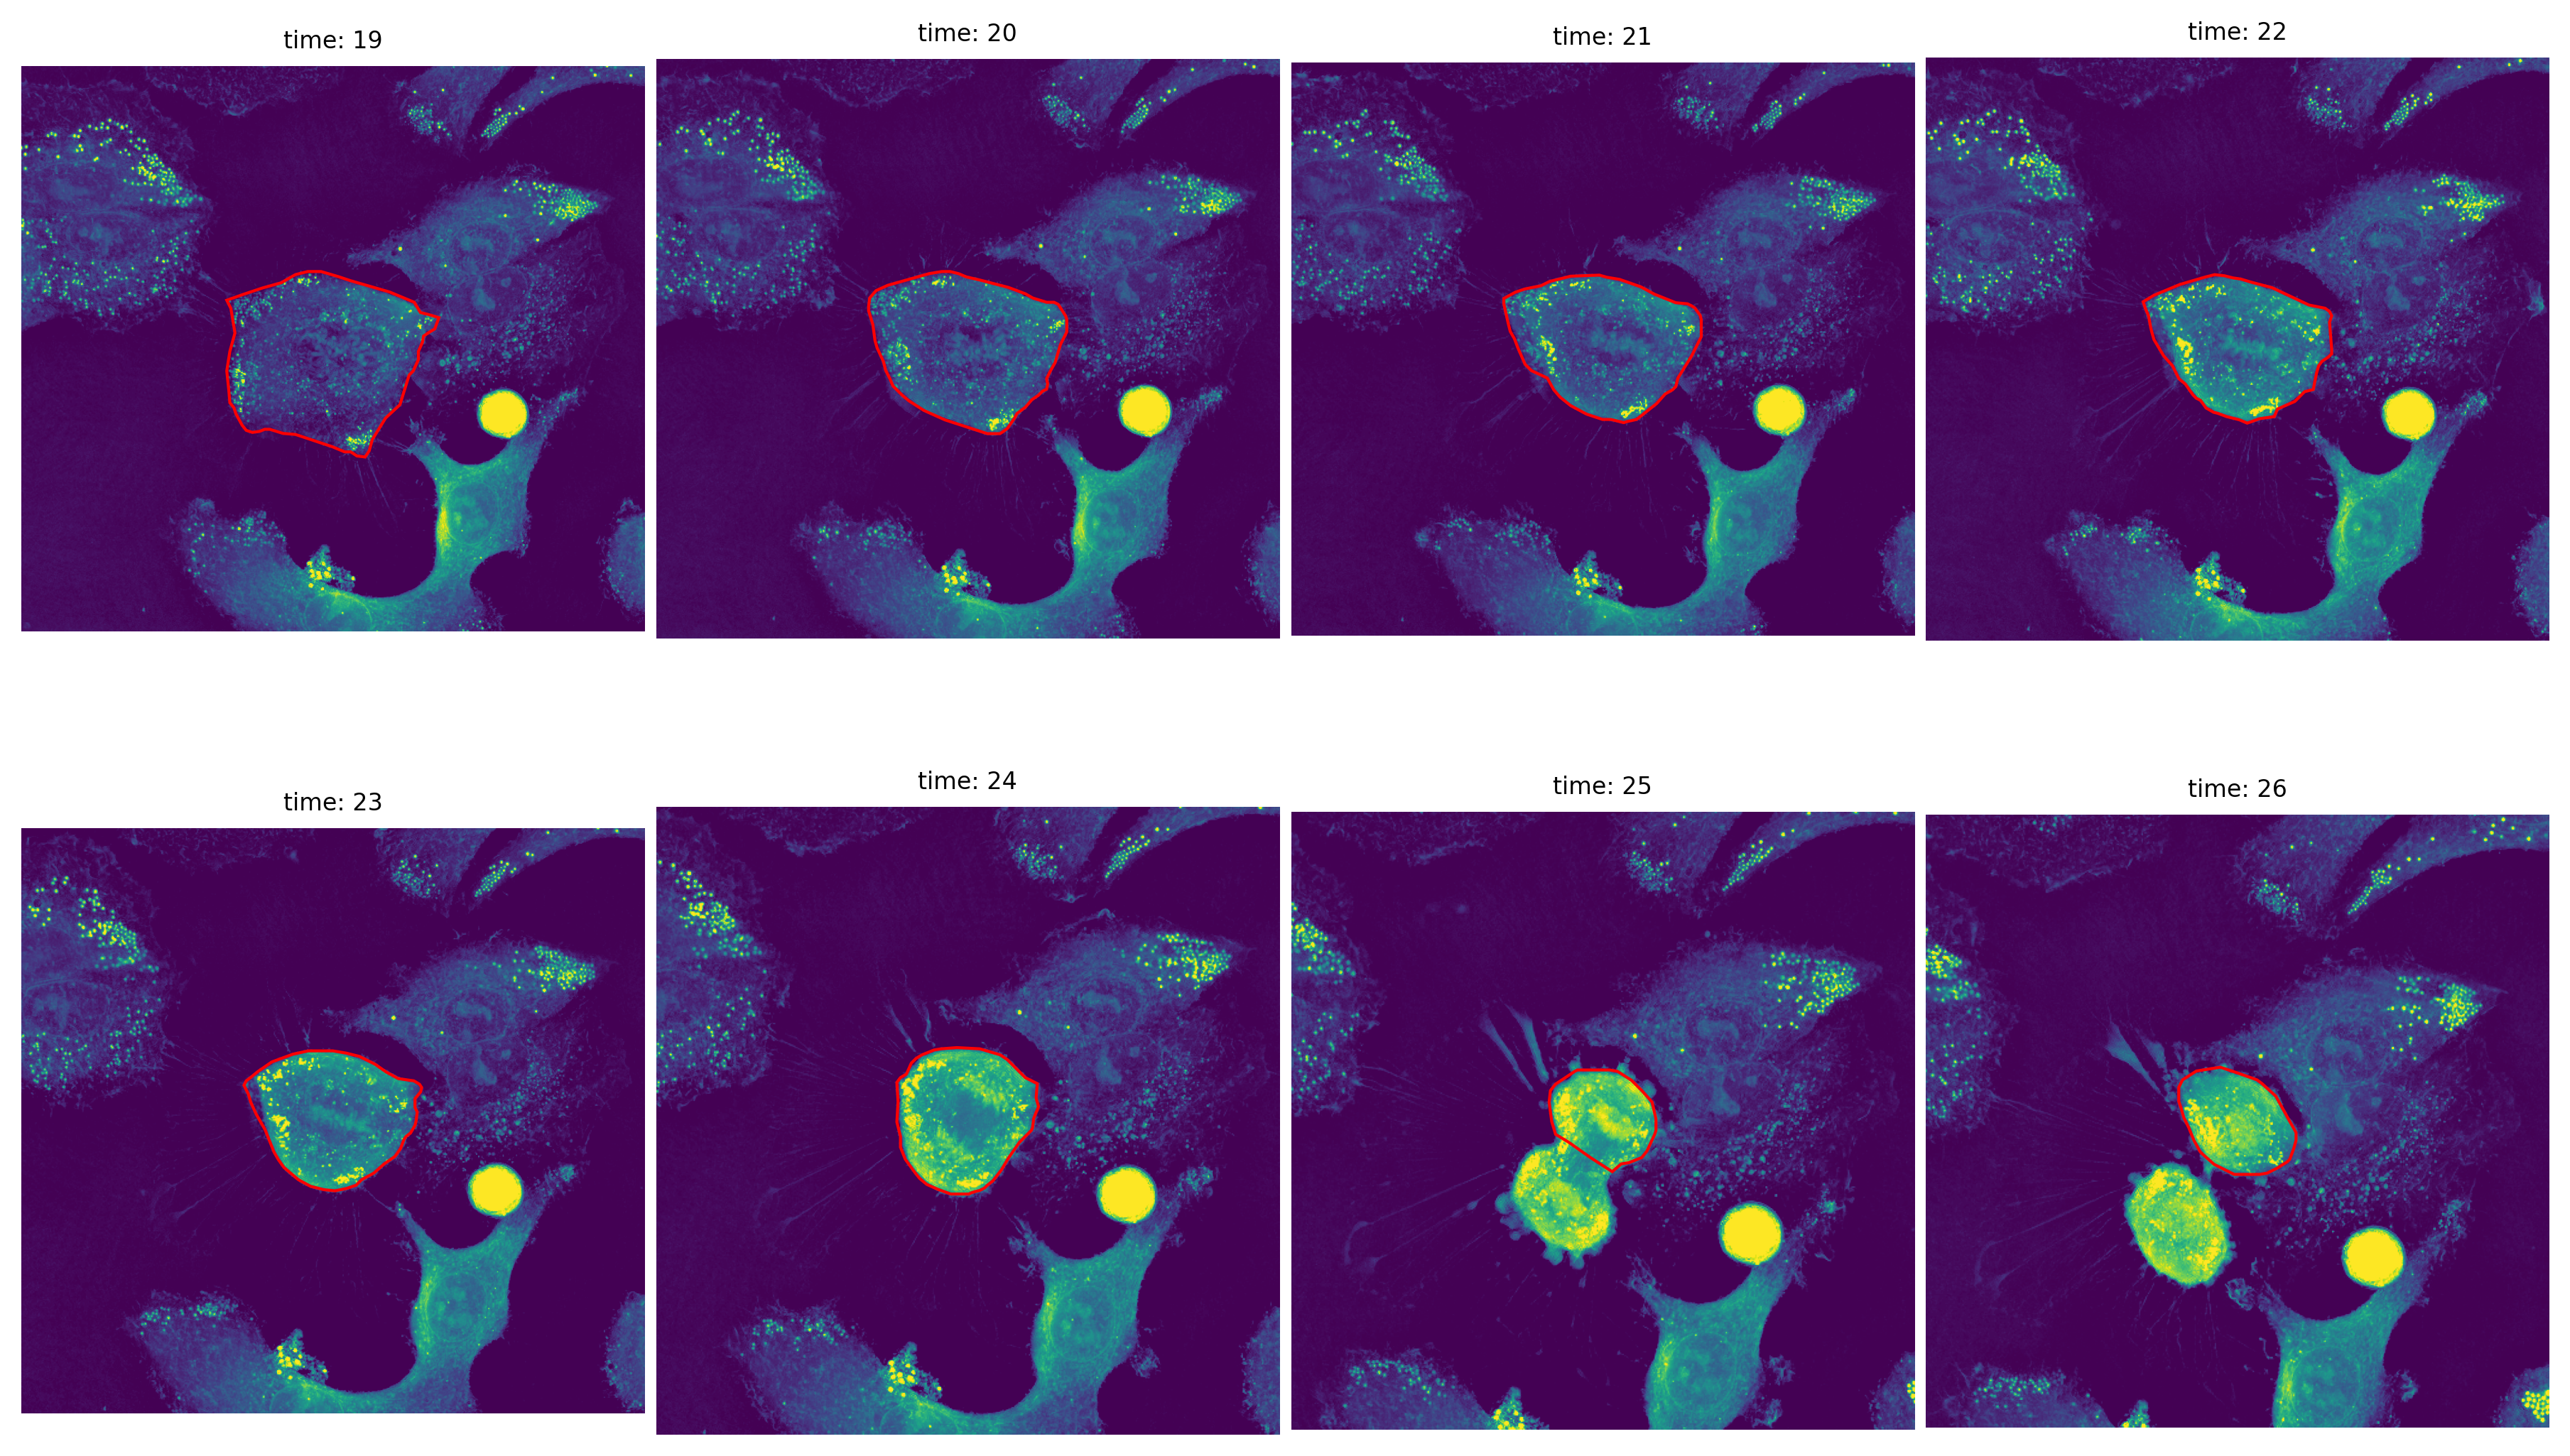

In [31]:
sample_traj = sdata[1]
sample_traj.show_on_grid(padding=200, ax_height=4, ax_width=3, nc=4, nr=2)

start timeframe larger than the first timeframe of the trajectory, replace start_timeframe with the first timeframe...


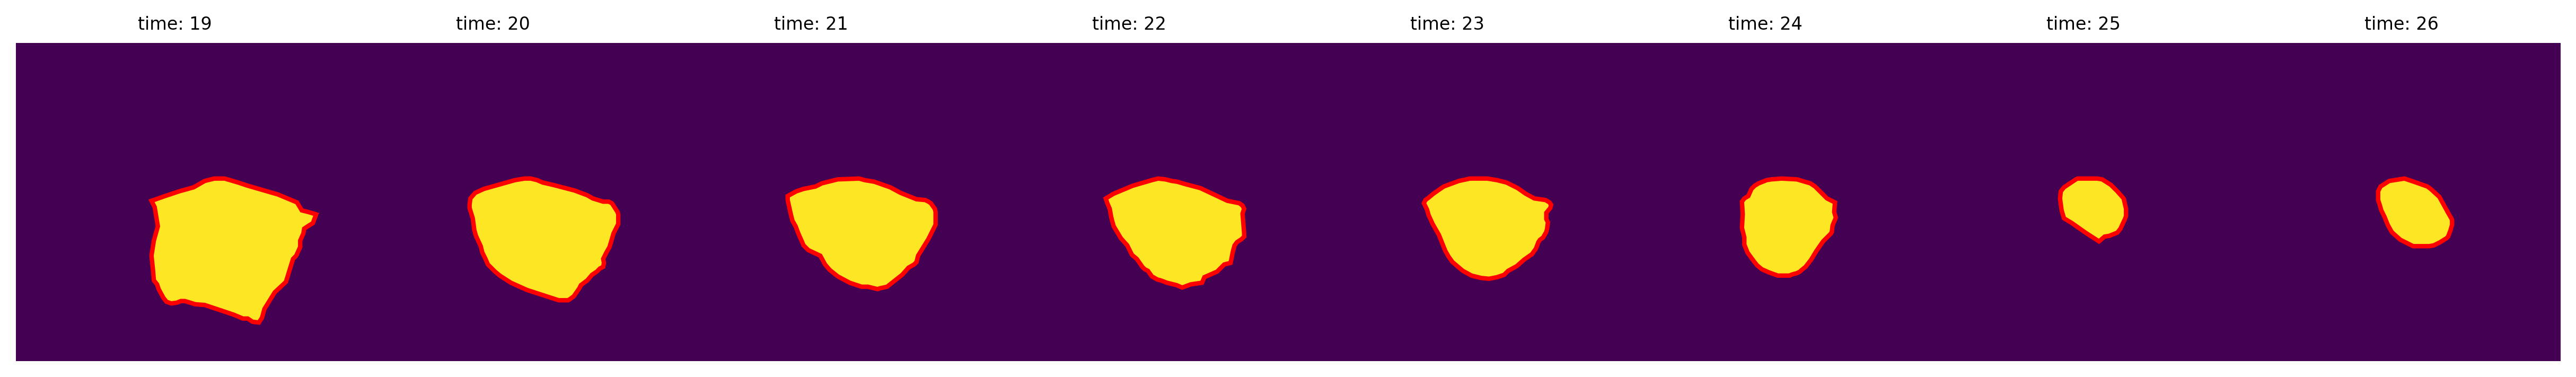

In [55]:
import importlib
importlib.reload(livecellx.core.single_cell)

fig, axes = livecellx.core.single_cell.show_sct_on_grid(sample_traj, padding=200, ax_height=3, ax_width=2, dims=[400, 400], dims_offset=[30, 30],  nc=8, nr=1, 
                                                        dpi=300,
                                                        ax_contour_polygon_kwargs={
                                                            "edgecolor": "red",
                                                            "linewidth": 2,
                                                            "facecolor": "none"
                                                        },
                                                        show_mask=True)
                                                        
# sample_traj.show_on_grid(padding=200, ax_height=3, ax_width=2, dims=[400, 400], dims_offset=[30, 30],  nc=4, nr=2, dpi=300)
fig.tight_layout(pad=0, h_pad=0, w_pad=0)

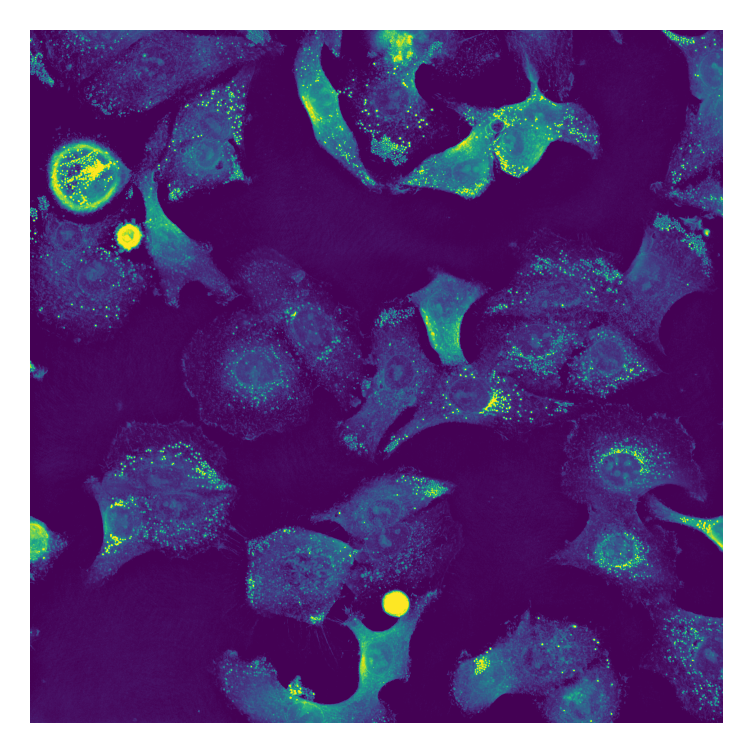

array([<Axes: title={'center': 'img'}>, <Axes: title={'center': 'mask'}>,
       <Axes: title={'center': 'contour_img'}>,
       <Axes: title={'center': 'contour_mask'}>,
       <Axes: title={'center': 'label_crop'}>,
       <Axes: title={'center': 'img_crop'}>], dtype=object)

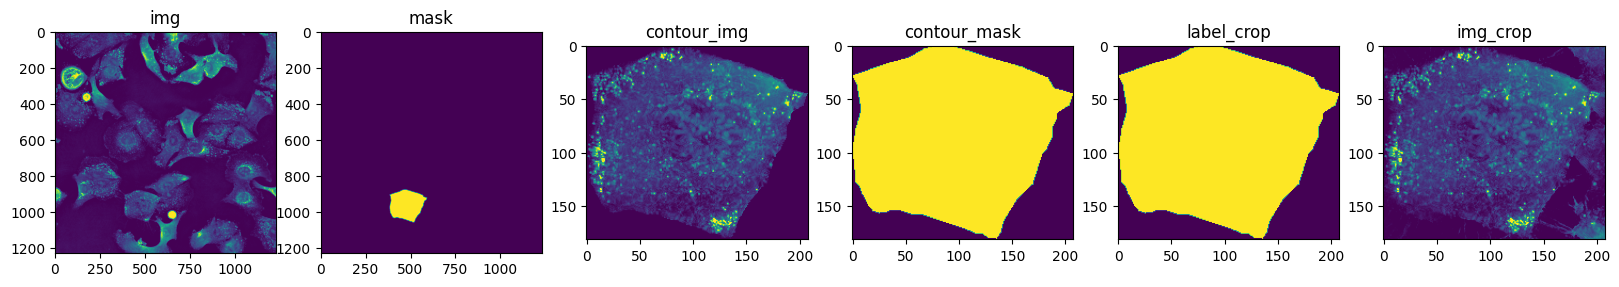

In [54]:
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(sample_traj.get_all_scs()[0].get_img())
# close all axes
plt.axis('off')
plt.show()
sample_traj.get_all_scs()[0].show_panel()